# Automated ML

Import Dependencies. In the cell below, import all the dependencies that are needed to complete the project.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import datasets
import logging
import json
import requests
import os

# !pip install kaggle
# import kaggle

import azureml.core
from azureml.pipeline.steps import AutoMLStep
from azureml.widgets import RunDetails

from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.dataset import Dataset
from azureml.core.environment import Environment
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, Webservice
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.train.automl import AutoMLConfig

import joblib

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.49.0


### Initialization

Initialize a workspace object from persisted configuration

In [2]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

# choose a name for experiment
experiment_name = 'AutoML_experiment'
project_folder = './training'

experiment=Experiment(ws, experiment_name)

run = experiment.start_logging()

# Choose a name for your CPU cluster
cluster_name = "compute-cluster-p31"

# Create compute cluster
try:
    aml_compute = ComputeTarget(workspace=ws, name=cluster_name)
    print('An existing cluster will be used!')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2', max_nodes=4)
    aml_compute = ComputeTarget.create(ws, cluster_name, compute_config)
    print('An new cluster will be created now!')

aml_compute.wait_for_completion(show_output=True)

quick-starts-ws-231770
aml-quickstarts-231770
southcentralus
5a4ab2ba-6c51-4805-8155-58759ad589d8
An new cluster will be created now!
InProgress..
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


### Data
The dataset for heart failure prediction was taken from kaggle and is saved locally. The code first tries to use that and if not reachable extract the data from the provided link.

The data includes several columns, namely:
`age`, `anaemia`, `creatinine_phosphokinase`, `diabetes`, `ejection_fraction`, `high_blood_pressure`, `platelets`, `serum_creainine`, `serum_sodium`, `sex`, `smoking`, `time` and `DEATH_EVENT`.

The patients `DEATH_EVENT` will be predicted based on the the other parameters listed in the dataset.

In [3]:
# Try to load the dataset from the Workspace. Otherwise, create it from the file
# update the key to match the dataset name
found = False
key = "Experiment"
description_text = "Heart Failure Prediction - Capstone Project"

if key in ws.datasets.keys(): 
        found = True
        dataset = ws.datasets[key] 

if not found:
        # Create AML Dataset and register it into Workspace
        url = "https://raw.githubusercontent.com/mirsadraee/Udacity_ND_Azure_Machine_Learning_Projects/develop/Project_03/heart_failure_clinical_records_dataset.csv"
        dataset = Dataset.Tabular.from_delimited_files(url)        
        #Register Dataset in Workspace
        dataset = dataset.register(workspace=ws,
                                   name=key,
                                   description=description_text)


df = dataset.to_pandas_dataframe()
df.head(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


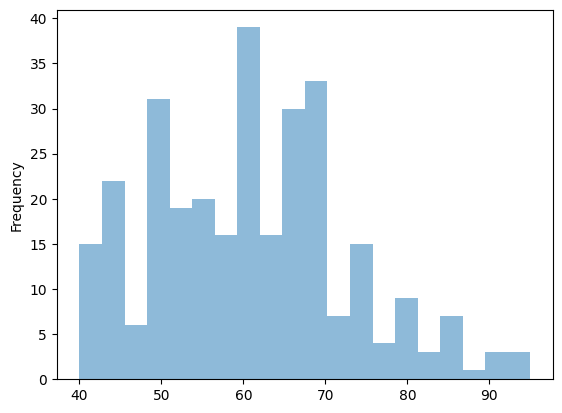

In [4]:
df['age'].plot.hist(bins=20, alpha=0.5)

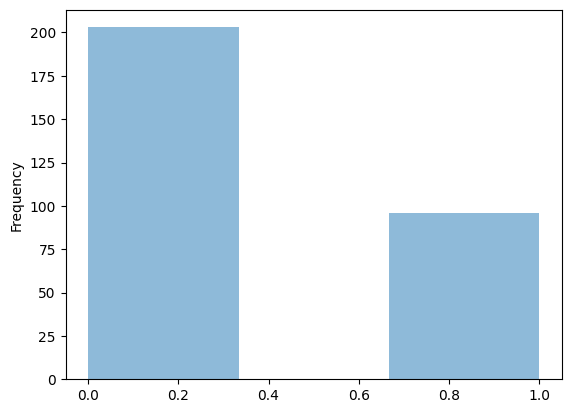

In [5]:
df['smoking'].plot.hist(bins=3, alpha=0.5)

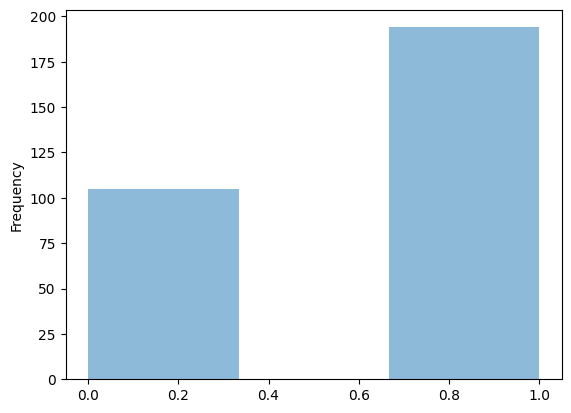

In [6]:
df['sex'].plot.hist(bins=3, alpha=0.5)

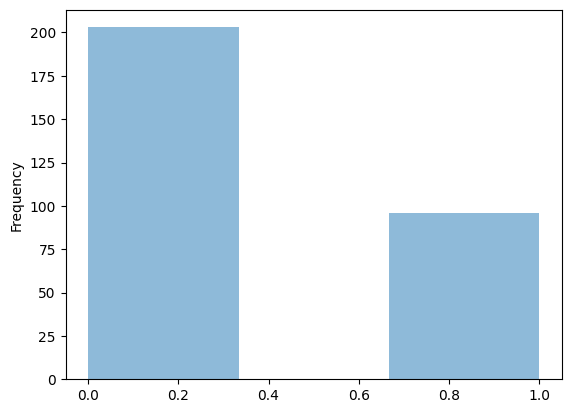

In [7]:
df['DEATH_EVENT'].plot.hist(bins=3, alpha=0.5)

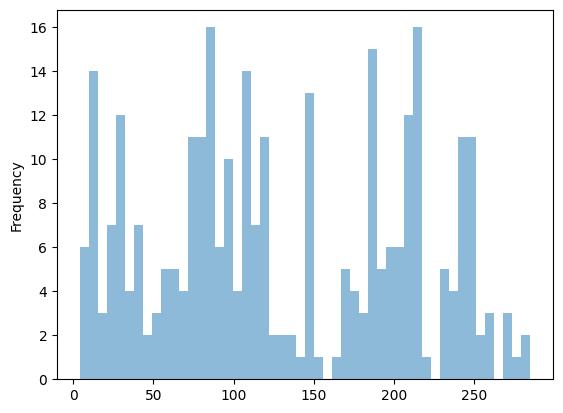

In [8]:
df['time'].plot.hist(bins=50, alpha=0.5)

## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [9]:
# Automl settings
automl_settings = {"n_cross_validations": 2,
                   "primary_metric": 'accuracy',
                   "enable_early_stopping": True,
                   "max_concurrent_iterations": 4,
                   "experiment_timeout_minutes": 20,
                   "verbosity": logging.INFO
                   }

# Parameters for AutoMLConfig
automl_config = AutoMLConfig(compute_target = aml_compute,
                            task='classification',
                            training_data=dataset,
                            label_column_name='DEATH_EVENT',
                            path = project_folder,
                            featurization= 'auto',
                            debug_log = "automl_errors.log",
                            enable_onnx_compatible_models=False,
                            **automl_settings
                            )

In [10]:
# Submit the experiment
remote_run = experiment.submit(automl_config, show_output = True)
remote_run.wait_for_completion()

Submitting remote run.
No run_configuration provided, running on compute-cluster-p31 with default configuration
Running on remote compute: compute-cluster-p31


Experiment,Id,Type,Status,Details Page,Docs Page
AutoML_experiment,AutoML_e0f592f9-6361-420e-ad67-b0a031ec87f6,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

********************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

**********************************************************************************

{'runId': 'AutoML_e0f592f9-6361-420e-ad67-b0a031ec87f6',
 'target': 'compute-cluster-p31',
 'status': 'Completed',
 'startTimeUtc': '2023-04-23T15:05:52.106708Z',
 'endTimeUtc': '2023-04-23T15:32:58.400341Z',
 'services': {},
 'warnings': [{'source': 'JasmineService',
   'message': 'No scores improved over last 10 iterations, so experiment stopped early. This early stopping behavior can be disabled by setting enable_early_stopping = False in AutoMLConfig for notebook/python SDK runs.'}],
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '2',
  'target': 'compute-cluster-p31',
  'AMLSettingsJsonString': '{"path":null,"name":"AutoML_experiment","subscription_id":"5a4ab2ba-6c51-4805-8155-58759ad589d8","resource_group":"aml-quickstarts-231770","workspace_name":"quick-starts-ws-231770","region":"southcentralus","compute_targe

## Run Details
To use the `RunDetails` widget to show the different experiments.

In [11]:
RunDetails(remote_run).show()
remote_run.wait_for_completion()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

{'runId': 'AutoML_e0f592f9-6361-420e-ad67-b0a031ec87f6',
 'target': 'compute-cluster-p31',
 'status': 'Completed',
 'startTimeUtc': '2023-04-23T15:05:52.106708Z',
 'endTimeUtc': '2023-04-23T15:32:58.400341Z',
 'services': {},
 'warnings': [{'source': 'JasmineService',
   'message': 'No scores improved over last 10 iterations, so experiment stopped early. This early stopping behavior can be disabled by setting enable_early_stopping = False in AutoMLConfig for notebook/python SDK runs.'}],
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '2',
  'target': 'compute-cluster-p31',
  'AMLSettingsJsonString': '{"path":null,"name":"AutoML_experiment","subscription_id":"5a4ab2ba-6c51-4805-8155-58759ad589d8","resource_group":"aml-quickstarts-231770","workspace_name":"quick-starts-ws-231770","region":"southcentralus","compute_targe

## Best Model
In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [12]:
best_automl_run, fitted_automl_model = remote_run.get_output()

best_automl_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutoML_experiment,AutoML_e0f592f9-6361-420e-ad67-b0a031ec87f6_37,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [13]:
best_automl_run.register_model(model_name = "AutoML_best_run.pkl", model_path = './outputs/')

print(best_automl_run)


Run(Experiment: AutoML_experiment,
Id: AutoML_e0f592f9-6361-420e-ad67-b0a031ec87f6_37,
Type: azureml.scriptrun,
Status: Completed)


In [17]:
# Save the best model
joblib.dump(fitted_automl_model, 'outputs/AutoML_best_run.pkl')

['outputs/AutoML_best_run.pkl']

## Model Deployment

Remember you have to deploy only one of the two models you trained but you still need to register both the models. Perform the steps in the rest of this notebook only if you wish to deploy this model.

In the cell below,  following steps are taken place:
- register the model, 
- create an inference config and 
- deploy the model as a web service.

In [19]:
# register the model
model = remote_run.register_model(model_name = "AutoML_Model")

# deploy the model
deploy_config = AciWebservice.deploy_configuration(cpu_cores=1,memory_gb=2,enable_app_insights=True)

# configure the inference
# An inference config in Azure Machine Learning is used to define the environment and entry script required to deploy a model as a web service.
inference_config = InferenceConfig(entry_script='./score.py')

service_name = 'automl-web-service'
service = Model.deploy(ws, service_name, [model], inference_config, deployment_config=deploy_config)
service.wait_for_deployment(True)

print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2023-04-23 15:39:20+00:00 Creating Container Registry if not exists.
2023-04-23 15:39:21+00:00 Use the existing image.
2023-04-23 15:39:22+00:00 Submitting deployment to compute.
2023-04-23 15:39:27+00:00 Checking the status of deployment automl-web-service..
2023-04-23 15:41:31+00:00 Checking the status of inference endpoint automl-web-service.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In the cell below, a request is sent to the web service to test it.

In [25]:
scoring_uri = service.scoring_uri

headers = {'Content-Type':'application/json'}

test_data_1 = json.dumps({'data':[{
    'age':75,
    'anaemia':0,
    'creatinine_phosphokinase':582,
    'diabetes':0,
    'ejection_fraction':20,
    'high_blood_pressure':1,
    'platelets':265000,
    'serum_creatinine':1.9,
    'serum_sodium':130,
    'sex':1,
    'smoking':0,
    'time':4}
    ]
        })

test_data_2 = json.dumps({'data':[{
    'age':40,
    'anaemia':0,
    'creatinine_phosphokinase':321,
    'diabetes':0,
    'ejection_fraction':35,
    'high_blood_pressure':0,
    'platelets':265000,
    'serum_creatinine':1,
    'serum_sodium':130,
    'sex':1,
    'smoking':0,
    'time':198}
    ]
        })

print("Test case 1:",requests.post(scoring_uri, data=test_data_1, headers=headers).text)
print("Test case 2:",requests.post(scoring_uri, data=test_data_2, headers=headers).text)

Test case 1: "{\"result\": [1]}"
Test case 2: "{\"result\": [0]}"


The logs of the web service are printed.

In [26]:
service.get_logs()

'2023-04-23T15:41:18,694265600+00:00 - rsyslog/run \n2023-04-23T15:41:18,703559600+00:00 - gunicorn/run \n2023-04-23T15:41:18,706354000+00:00 | gunicorn/run | \n2023-04-23T15:41:18,713935600+00:00 | gunicorn/run | ###############################################\n2023-04-23T15:41:18,717044200+00:00 | gunicorn/run | AzureML Container Runtime Information\n2023-04-23T15:41:18,722095600+00:00 | gunicorn/run | ###############################################\n2023-04-23T15:41:18,725724400+00:00 | gunicorn/run | \n2023-04-23T15:41:18,738918300+00:00 | gunicorn/run | \n2023-04-23T15:41:18,754006600+00:00 | gunicorn/run | AzureML image information: openmpi4.1.0-ubuntu20.04, Materializaton Build:20230324.v2\n2023-04-23T15:41:18,754242900+00:00 - nginx/run \n2023-04-23T15:41:18,761470000+00:00 | gunicorn/run | \n2023-04-23T15:41:18,765351900+00:00 | gunicorn/run | \n2023-04-23T15:41:18,767931800+00:00 | gunicorn/run | PATH environment variable: /azureml-envs/azureml-automl/bin:/opt/miniconda/bin:/

The service will be deleted now.

In [27]:
service.delete()

**Submission Checklist**
- [x]  I have registered the model.
- [x]  I have deployed the model with the best accuracy as a webservice.
- [x]  I have tested the webservice by sending a request to the model endpoint.
- [x]  I have deleted the webservice and shutdown all the computes that I have used.
- [x]  I have taken a screenshot showing the model endpoint as active.
- [x]  The project includes a file containing the environment details.
